In [2]:
# DT2119, Lab 1 Feature Extraction
import numpy as np
import matplotlib.pylab as plt
from scipy import signal, fftpack
from scipy.fftpack.realtransforms import dct
from lab1_tools import *

In [3]:

# Function given by the exercise ----------------------------------

def mfcc(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22, result = 'lmfcc'):
    """Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    mspec = logMelSpectrum(spec, samplingrate)
    if(result == 'mspec'):
        return mspec
    ceps = cepstrum(mspec, nceps)
    if(result == 'mfcc'):
        return ceps
    return lifter(ceps, liftercoeff)

# Functions to be implemented ----------------------------------

def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    A = np.array(samples[0:winlen].reshape((1, winlen)))
    stepsize = winlen - winshift
    for i in range(stepsize, len(samples) - winlen, stepsize):
        A = np.vstack((A, samples[i:i+winlen].reshape((1, winlen))))
    return A

def preemp(input, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """
    a = [1]
    b = [1, -p]
    return signal.lfilter(b, a, input, zi=None)

def windowing(input):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windoed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    window = signal.hamming(input.shape[1], sym=False)
    for idx, row in enumerate(input):
        input[idx] = window * input[idx]
    return input

def powerSpectrum(input, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """
    return np.power(np.abs(fftpack.fft(input, nfft)), 2)

def logMelSpectrum(input, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in tools.py to calculate the filterbank shapes and
          nmelfilters
    """
    T = trfbank(samplingrate, 512, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False)
    #Plot filter bank
    #for i in range(len(T)):
        #plt.plot(np.transpose(T[i]))
    #plt.show()
    Spec = np.dot(input, T.T)
    Spec = np.where(Spec == 0.0, np.finfo(float).eps, Spec)  # Numerical Stability
    return np.log(Spec)

def cepstrum(input, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    mfcc = dct(input)[:,0:nceps]
    return mfcc


def minAD(accD, i, j):
    if(i == 0 and j == 0):
        return 0
    elif (i == 0):
        return accD[i, j - 1]
    elif (j == 0):
        return accD[i - 1, j]
    minimum = accD[i - 1, j]
    if(accD[i - 1, j - 1] < minimum):
        minimum = accD[i - 1, j - 1]
    if(accD[i, j - 1] < minimum):
        minimum = accD[i, j - 1]
    return minimum

def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """
    N = x.shape[0]
    M = y.shape[0]
    LD = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            LD[i,j] = dist(x[i] - y[j])
    #plt.pcolormesh(locD)
    #plt.show()
    AD = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            AD[i,j] = LD[i, j] + minAD(AD, i, j)
    d = AD[N - 1, M - 1] / (N + M)
    path = backtrack(AD)
    #plt.pcolormesh(accD)
    #plt.show()
    return d, LD, AD, path

def backtrack(AD):
    """
    Returns best path through accumulated distance matrix AD
    """
    N = AD.shape[0]
    M = AD.shape[1]
    path = [(N - 1, M - 1)]
    i = N - 1
    j = M - 1
    while(i > 0 or j > 0):
        if( i > 0 and j > 0):
            argmin = np.argmin([AD[i - 1, j - 1], AD[i - 1, j], AD[i, j - 1]])
            if(argmin == 0):
                path.append((i - 1, j - 1))
                i = i - 1
                j = j - 1
            elif(argmin == 1):
                path.append((i - 1, j))
                i = i - 1
            elif(argmin == 2):
                path.append((i, j - 1))
                j = j - 1
        elif(i == 0 and j > 0):
            path.append((0, j - 1))
            j = j - 1
        else:
            path.append((i - 1, 0))
            i = i - 1
    return path

def compare(X, Y):
    """
    Plots a colormesh for each matrix and returns True if they are equal and
    false otherwise
    """
#     plt.pcolormesh(X)
#     plt.show()
#     plt.pcolormesh(Y)
#     plt.show()
    return np.allclose(X, Y)


Compare the result with the gound truth.

In [5]:
example = np.load('lab1_example.npz',
                  allow_pickle=True)['example'].item()

#####STEP BY STEP FEATURE EXTRACTION FROM EXAMPLE DATA####
A = enframe(example['samples'], 400, 200)
print(compare(A, example['frames']))
P = preemp(A, 0.97)
print(compare(P, example['preemph']))
H = windowing(P)
print(compare(P, example['windowed']))
S = powerSpectrum(H, 512)
print(compare(S, example['spec']))
L = logMelSpectrum(S, 20000)
print(compare(L, example['mspec']))
D = cepstrum(L, 13)
print(compare(D, example['mfcc']))
## LIFTERED MFCC FEATURE EXTRACTION

LMFCC = mfcc(example['samples'], winlen = 400, winshift = 200, preempcoeff=0.97,
                        nfft=512, nceps=13, samplingrate=20000, liftercoeff=22)
print(compare(LMFCC, example['lmfcc']))


True
True
True
True
True
True
True


### liftered MFCCs Feature

In [7]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']

##############EXTRACT FEATURES FROM ALL UTTERANCES#####################
sampled_signals = []
signal_features = []
for idx, sample in enumerate(data):
    sampled_signal = sample['samples']
    sampled_signals.append(sampled_signal)
    extracted_features = mfcc(sampled_signal, winlen = 400, winshift = 200, preempcoeff=0.97,
                            nfft=512, nceps=13, samplingrate=20000, liftercoeff=22, result = 'lmfcc')
    signal_features.append(extracted_features)
    #plt.pcolormesh(extracted_features)
    #plt.savefig(str(idx) + "_" + sample['gender'] + "_" + sample['digit'] + "_"
                    #+ sample['speaker'] + "_" + sample['repetition'],
                    #bbox_inches='tight')

# np.savez("./data/lmfcc_utterance_features.npz",signal_features)


### MFCC Feature

In [9]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']

##############EXTRACT FEATURES FROM ALL UTTERANCES#####################
sampled_signals = []
signal_features = []
for idx, sample in enumerate(data):
    sampled_signal = sample['samples']
    sampled_signals.append(sampled_signal)
    extracted_features = mfcc(sampled_signal, winlen = 400, winshift = 200, preempcoeff=0.97,
                            nfft=512, nceps=13, samplingrate=20000, liftercoeff=22, result = 'mfcc')
    signal_features.append(extracted_features)
    #plt.pcolormesh(extracted_features)
    #plt.savefig(str(idx) + "_" + sample['gender'] + "_" + sample['digit'] + "_"
                    #+ sample['speaker'] + "_" + sample['repetition'],
                    #bbox_inches='tight')

np.savez("./data/mfcc_utterance_features.npz",signal_features)


### Mel filterbank Feature

In [10]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']

##############EXTRACT FEATURES FROM ALL UTTERANCES#####################
sampled_signals = []
signal_features = []
for idx, sample in enumerate(data):
    sampled_signal = sample['samples']
    sampled_signals.append(sampled_signal)
    extracted_features = mfcc(sampled_signal, winlen = 400, winshift = 200, preempcoeff=0.97,
                            nfft=512, nceps=13, samplingrate=20000, liftercoeff=22, result = 'mspec')
    signal_features.append(extracted_features)
    #plt.pcolormesh(extracted_features)
    #plt.savefig(str(idx) + "_" + sample['gender'] + "_" + sample['digit'] + "_"
                    #+ sample['speaker'] + "_" + sample['repetition'],
                    #bbox_inches='tight')

np.savez("./data/mspec_utterance_features.npz",signal_features)


### correlation coefficients

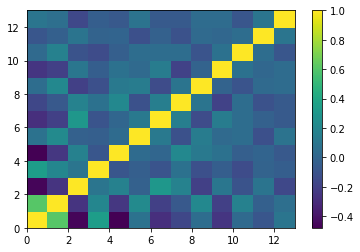

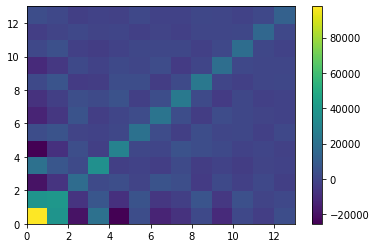

In [31]:
signal_features = np.load("./data/lmfcc_utterance_features.npz", allow_pickle=True)['arr_0']
# signal_features = np.load("./data/mfcc_utterance_features.npz", allow_pickle=True)['arr_0']
# signal_features = np.load("./data/mspec_utterance_features.npz", allow_pickle=True)['arr_0']

# Stack features on top of each other
feature_matrix = signal_features[0]
for i in range(1, len(signal_features)):
    feature_matrix = np.vstack((feature_matrix, signal_features[i]))
correlation_matix = np.corrcoef(feature_matrix, rowvar = False)
covariance_matrix = np.cov(feature_matrix, rowvar = False)
plt.pcolormesh(correlation_matix)
plt.colorbar()
plt.show()
plt.pcolormesh(covariance_matrix)
plt.colorbar()
plt.show()

### global distance

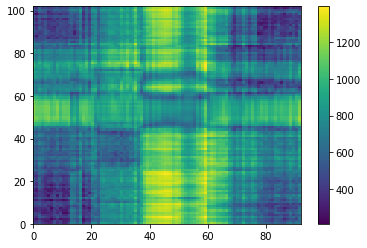

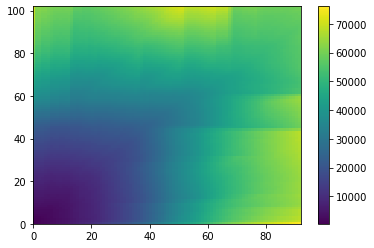

In [29]:
signal_features = np.load("./data/lmfcc_utterance_features.npz", allow_pickle=True)['arr_0']

# Dynamic Time Warping for 'seven' uttered by man and woman
d, LD, AD, path = dtw(signal_features[38], signal_features[16], np.linalg.norm)
plt.pcolormesh(LD)
plt.colorbar()
plt.show()
plt.pcolormesh(AD)
plt.colorbar()
plt.show()

In [ ]:
# Dynamic time warping between all signal_features
global_distances = np.zeros((len(signal_features), len(signal_features)))
for i in range(len(signal_features)):
    for j in range(len(signal_features)):
        d, LD, AD, path = dtw(signal_features[i], signal_features[j], np.linalg.norm)
        global_distances[i, j] = d
np.save('./data/global_distance_matrix.npy', global_distances)

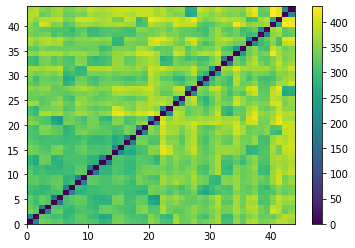

In [28]:
global_distances = np.load('./data/global_distance_matrix.npy', allow_pickle=True)
plt.pcolormesh(global_distances)
plt.colorbar()
plt.show()

### hierarchical clustering

C:\Users\zth\anaconda3\lib\site-packages\ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


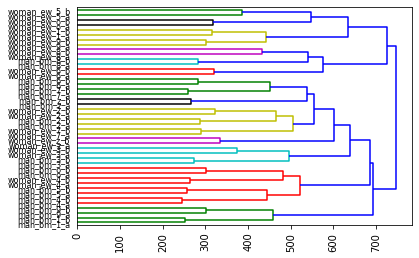

In [34]:
from scipy.cluster.hierarchy import linkage, dendrogram
from lab1_tools import tidigit2labels as getLabels

dataset = np.load('lab1_data.npz', allow_pickle=True)['data']
labels = getLabels(dataset)

D = np.load('./data/global_distance_matrix.npy', allow_pickle=True)
linkage_matrix = linkage(D, method = 'complete')
plt.xticks(rotation=90)
dendrogram(linkage_matrix, labels = labels, orientation = 'right')
plt.savefig('hierarchical clustering')
plt.show()

## Explore Speech Segments with Clustering

In [53]:
data = np.load('lab1_data.npz',allow_pickle=True)['data']

sampled_signals = []
signal_features = []
for idx, sample in enumerate(data):
    sampled_signal = sample['samples']
    sampled_signals.append(sampled_signal)
    extracted_features = mfcc(sampled_signal, winlen = 400, winshift = 200, preempcoeff=0.97,
                            nfft=512, nceps=13, samplingrate=20000, liftercoeff=22, result = 'lmfcc')
    signal_features.append(extracted_features)
print(signal_features[0].shape)

(16640,)
(82, 13)


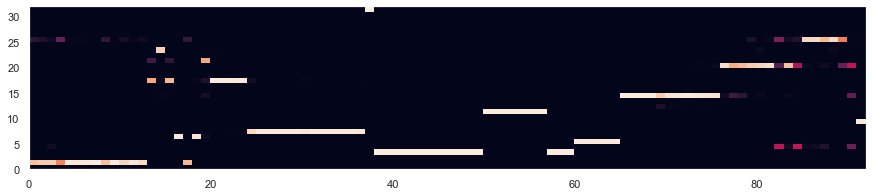

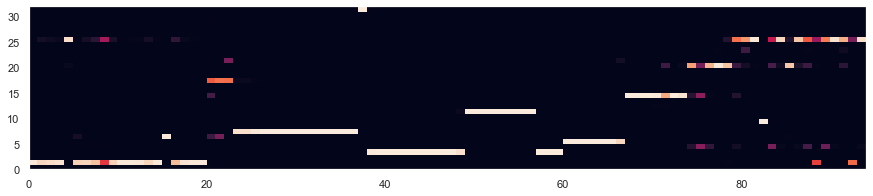

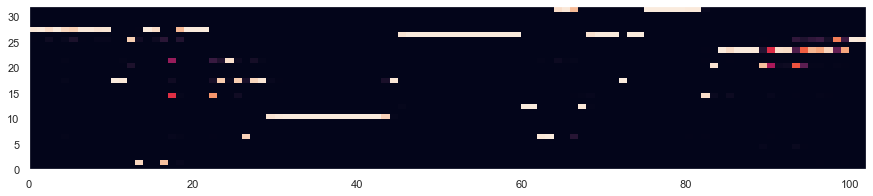

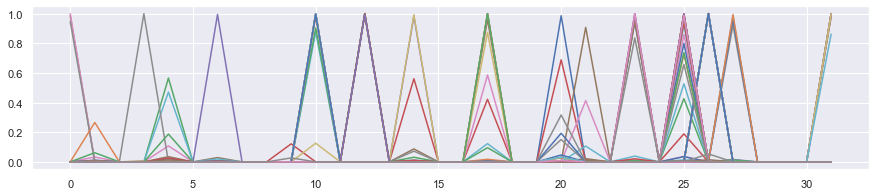

In [48]:
from sklearn.mixture import GaussianMixture


features = signal_features[0]
for idx, sample_features in enumerate(signal_features):
    if(idx > 0):
        features = np.vstack((features, sample_features))

component_number = 32
utterances = [signal_features[16], signal_features[17], \
                signal_features[38], signal_features[39]]

model = GaussianMixture(component_number)
model.fit(features)
cluster_labels = []
posteriors = []
for utterance in utterances:
    cluster_labels.append(list(model.predict(utterance)))
    posteriors.append(model.predict_proba(utterance))


plt.pcolormesh(posteriors[0].T)
# plt.savefig('PosteriorMan7_1_' + str(component_number) + '.png')
plt.show()
plt.pcolormesh(posteriors[1].T)
# plt.savefig('PosteriorMan7_2_' + str(component_number) + '.png')
plt.show()
plt.pcolormesh(posteriors[2].T)
# plt.savefig('PosteriorWoman7_1_' + str(component_number) + '.png')
plt.show()
plt.plot(posteriors[3].T)
# plt.savefig('PosteriorWoman7_2_' + str(component_number) + '.png')
plt.show()